This notebook provides instructions about model evaluation.

In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import sys
import pandas as pd
import torch
import os.path
sys.path.insert(0, '../../')
import topovelo as tpv
%load_ext autoreload
%autoreload 2

In [2]:
dataset = 'slide-seq-adult-cortex'
data_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/data/topovelo/slide-seq-brain-cortex'
figure_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}/gat'
model_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/topovelo_model/{dataset}/gat'

adata = sc.read(f'{data_path}/adata_out.h5ad')

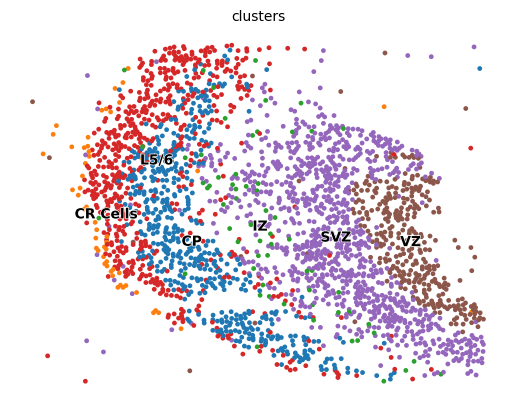

In [3]:
scv.pl.scatter(adata, basis='spatial')

## Evaluate a model

Here, we use `post_analysis` to calculate all performance metrics. The output contains 4 DataFrame objects:
1. res: rows are different metric names and columns are method/model names
2. res_type: rows are different metric names and columns are tuples of the form **(model name, A->B)**. Here A->B represents a known developmental relation.
3. multi_res: this is used to record certain metric, e.g. k-cbdir, which has multiple quantities for each metric. Rows are different metric names and columns are tuples of the form **(model name, step number)**.
4. multi_res_type: this is used to record metrics for each cell type transition pair A->B. Rows are different metric names and columns are tuples of the form **(model name, transition pair, step number)**.

Please see the examples below.

In [4]:
cluster_edges = [('VZ', 'SVZ'), ('SVZ', 'IZ'), ('IZ', 'CP'), ('CP', 'L5/6')]

# x axis indicates the developmental time due to layered growth
x = -adata.obsm['X_spatial'][:, 0]
tprior = 20 * (x - x.min())/(x.max() - x.min())
adata.obs['tprior'] = tprior

(res, res_type,
 multi_res, multi_res_type) = tpv.post_analysis(adata,
                                                'cortex',
                                                ['TopoVelo (GAT)'],
                                                ['gat'],
                                                cluster_edges=cluster_edges,
                                                spatial_velocity_graph=True,
                                                n_spatial_neighbors=50,
                                                spatial_key='X_spatial',
                                                spatial_graph_key='spatial_graph',
                                                compute_metrics=True,
                                                embed='spatial',
                                                plot_type=[])

['Map2']
Computing a spatial graph using KNN on X_spatial with k=50
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
*** Computing performance metrics 1/1 ***
computing velocity graph (using 1/32 cores)


  0%|          | 0/2525 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

---     Integrating Peformance Metrics     ---
Dataset Size: 2525 cells, 200 genes
---   Plotting  Results   ---


In [5]:
res

,TopoVelo (GAT)
CBDir,0.187
CBDir (Gene Space),0.046
LL Test,511.215
LL Train,516.498
MAE Test,0.161
MAE Train,0.156
MSE Test,0.493
MSE Train,0.280
Spatial Time Consistency,0.981
Spatial Velocity Consistency,0.990


In [6]:
res_type

Model              TopoVelo (GAT)                              
                        VZ -> SVZ SVZ -> IZ IZ -> CP CP -> L5/6
CBDir (Gene Space)          0.101     0.038    0.122     -0.076
CBDir                       0.290     0.051    0.337      0.071
Time Score                  0.963     0.856    0.955      0.248

In [7]:
multi_res

Model                                TopoVelo (GAT)                    \
                                             1-step   2-step   3-step   
K-CBDir (Gene Space)                         -0.106    0.002    0.151   
K-CBDir                                      -0.047    0.145    0.341   
Mann-Whitney Test (Gene Space)                0.001    0.000    0.000   
Mann-Whitney Test                             0.000    0.000    0.000   
Mann-Whitney Test Stats (Gene Space)         11.127  201.699  200.200   
Mann-Whitney Test Stats                      11.358  218.477  222.778   

Model                                                   
                                       4-step   5-step  
K-CBDir (Gene Space)                    0.242    0.295  
K-CBDir                                 0.423    0.460  
Mann-Whitney Test (Gene Space)          0.000    0.000  
Mann-Whitney Test                       0.000    0.000  
Mann-Whitney Test Stats (Gene Space)  200.526  192.059  
Mann-Whitney Test Stats               217.074  210.480

In [8]:
multi_res_type

Model                                TopoVelo (GAT)                    \
Transition                                VZ -> SVZ                     
Step                                         1-step   2-step   3-step   
K-CBDir (Gene Space)                          0.005    0.212    0.392   
K-CBDir                                       0.133    0.443    0.664   
Mann-Whitney Test (Gene Space)                0.000    0.000    0.000   
Mann-Whitney Test                             0.000    0.000    0.000   
Mann-Whitney Test Stats (Gene Space)         14.433  358.542  369.058   
Mann-Whitney Test Stats                      14.892  385.117  394.900   

Model                                                                     \
Transition                                             SVZ -> IZ           
Step                                   4-step   5-step    1-step  2-step   
K-CBDir (Gene Space)                    0.496    0.558    -0.190  -0.099   
K-CBDir                                 0.690    0.698    -0.155  -0.011   
Mann-Whitney Test (Gene Space)          0.000    0.000     0.000   0.000   
Mann-Whitney Test                       0.000    0.000     0.000   0.000   
Mann-Whitney Test Stats (Gene Space)  356.767  327.258     7.522  42.311   
Mann-Whitney Test Stats               377.933  351.117     7.689  46.978   

Model                                                                          \
Transition                                                  IZ -> CP            
Step                                  3-step  4-step 5-step   1-step   2-step   
K-CBDir (Gene Space)                  -0.040  -0.018 -0.010    0.039    0.099   
K-CBDir                                0.050   0.058  0.047    0.138    0.369   
Mann-Whitney Test (Gene Space)         0.000   0.000  0.000    0.000    0.000   
Mann-Whitney Test                      0.000   0.000  0.000    0.000    0.000   
Mann-Whitney Test Stats (Gene Space)  18.889  12.489  7.822   13.038  250.577   
Mann-Whitney Test Stats               21.833  10.611  7.322   12.923  267.615   

Model                                                                       \
Transition                                                      CP -> L5/6   
Step                                   3-step   4-step   5-step     1-step   
K-CBDir (Gene Space)                    0.309    0.398    0.447     -0.277   
K-CBDir                                 0.621    0.701    0.731     -0.305   
Mann-Whitney Test (Gene Space)          0.000    0.000    0.000      0.005   
Mann-Whitney Test                       0.000    0.000    0.000      0.000   
Mann-Whitney Test Stats (Gene Space)  246.923  249.423  243.731      9.515   
Mann-Whitney Test Stats               263.462  232.423  215.038      9.930   

Model                                                                     
Transition                                                                
Step                                   2-step   3-step   4-step   5-step  
K-CBDir (Gene Space)                   -0.203   -0.057    0.091    0.185  
K-CBDir                                -0.220    0.031    0.241    0.366  
Mann-Whitney Test (Gene Space)          0.000    0.000    0.000    0.000  
Mann-Whitney Test                       0.000    0.000    0.000    0.000  
Mann-Whitney Test Stats (Gene Space)  155.365  165.930  183.425  189.425  
Mann-Whitney Test Stats               174.200  210.917  247.330  268.442

# Use `PerfLogger` for benchmarking


The `PerfLogger` class from topovelo package records all the metrics above into a meta DataFrame. Hence, we can compare the performance of different models across multiple benchmark datasets.

## Step 1: create a `PerfLogger` object

In [9]:
perf_logger = tpv.PerfLogger(save_path=data_path)

## Step 2: add all results

In [10]:
dataset_name = 'slide-seq-adult-cortex'
perf_logger.insert(dataset_name, res, res_type, multi_res, multi_res_type)

## Step 3: save results

In [11]:
perf_logger.save('benchmark')

## Step 4: plotting

`plot` is the most general plotting function. It allows you to visualize all performance metrics calculated in `post_analysis`. 

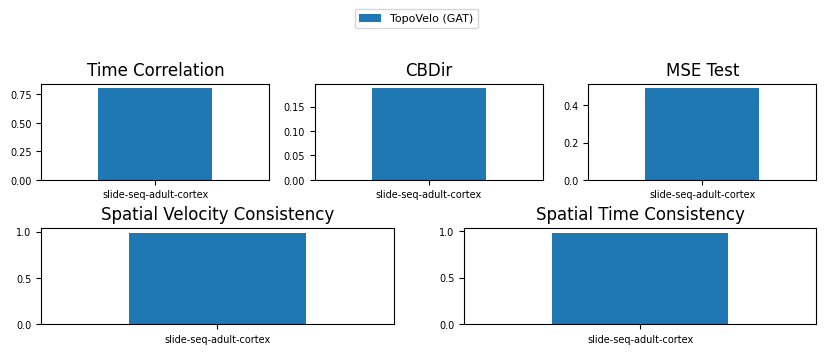

In [12]:
metrics = ['Time Correlation',
           'CBDir',
           'MSE Test',
           'Spatial Velocity Consistency',
           'Spatial Time Consistency']
perf_logger.plot(metrics,
                 legend_metric='CBDir',
                 figsize=(10, 5),
                 title_fontsize=12,
                 legend_fontsize=8,
                 ylabel_fontsize=8,
                 labelpad=0,
                 tick_fontsize=7,
                 hspace=0.5,
                 wspace=0.2,
                 ncols_legend=1,
                 bbox_to_anchor=(0, 1.0, 1.0, 0.02),
                 figure_path=figure_path,
                 figure_name='perf',
                 dpi=300,
                 save_format='png')

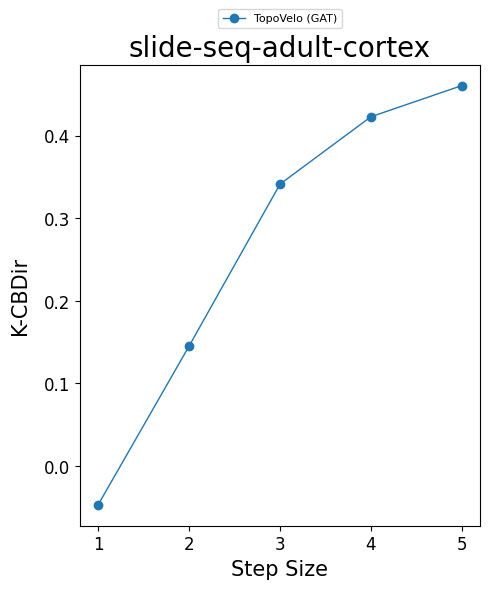

In [13]:
perf_logger.plot_velocity_metrics(metrics=['K-CBDir'], figure_path=figure_path)

`plot_summary` is used to visualize certain multi-dimensional metrics across all datasets. 

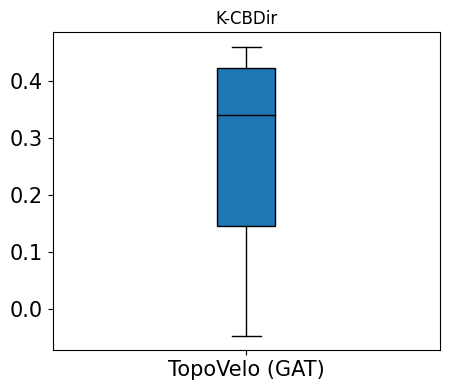

In [14]:
perf_logger.plot_summary(metrics=['K-CBDir'], figure_path=figure_path)